In [1]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
# import time
from bs4 import BeautifulSoup
import requests
import re

from PIL import Image
import matplotlib.pyplot as plt

# 책 코드 수집하기

## webdriver

In [62]:
import pandas as pd
from selenium import webdriver
import re
from selenium.webdriver.common.by import By


FILE = './crawling/book_review_north_Europe.csv'
NATIONAL_CODE = '017001045014'
PAGE_END = 12


options = webdriver.ChromeOptions()
options.add_argument('headless')
options.add_argument('disable-gpu')
options.add_argument('lang=ko_KR')
driver = webdriver.Chrome('./chromedriver', options=options)

# print(titles)

ATTR_BOOK_CODE = 'href'
BOOK_CODE = re.compile(r'Goods/(.+)$')
CSS_BOOK_TITLE = "#category_layout .goods_name > a:first-of-type"

titles = {}

try:
    for i in range(1, PAGE_END):
        driver.get(f'http://www.yes24.com/24/Category/Display/{NATIONAL_CODE}?ParamSortTp=03&PageNumber={i}')

        books = driver.find_elements(By.CSS_SELECTOR, CSS_BOOK_TITLE)

        for book in books:
            if '체험판' in book.text:
                continue
            code = BOOK_CODE.findall(book.get_attribute(ATTR_BOOK_CODE))[0]
            titles[code] = book.text

    df_title = pd.DataFrame(titles.items(), columns=['code', 'title'])
    df_title.set_index('code', inplace=True)
    df_title.to_csv(FILE)
    
finally:
    driver.close()

In [15]:
NATIONAL_CODE = "017001045012"
FILE_NAME = './crawling/book_code_russian.csv'

##############################################################################
CHROMEDRIVER = '../resources/chromedriver'

def get_url(page=1):
    return f"http://www.yes24.com/24/Category/Display/{NATIONAL_CODE}?ParamSortTp=03&AO=2&PageNumber={page}"


# CSS selector
CSS_BOOK_TITLE = '#category_layout .goods_name > a:first-of-type'
CSS_END_BUTTON = '.bgYUI.end'

# Attributes & RE patterns
ATTR_BOOK_CODE = 'href'
PAT_BOOK_CODE = re.compile(r'Goods/(.+)$')

ATTR_END_PAGE = 'href'
PAT_END_PAGE =r'(?<=PageNumber=).+$'

# 체험판 제외
REMOVAL_TYPE = "체험판"
##############################################################################

# Chromedriver 설정
options = webdriver.ChromeOptions()
options.add_argument('headless')
options.add_argument('disable-gpu')
options.add_argument('lang=ko_KR')
driver = webdriver.Chrome(CHROMEDRIVER, options=options)

# 목록 첫 페이지로 이동
driver.get(get_url())

# 제일 마지막 페이지 정보 수집
end_btn = driver.find_elements(By.CSS_SELECTOR, CSS_END_BUTTON)[0]
end_page = re.search(PAT_END_PAGE, end_btn.get_attribute(ATTR_END_PAGE)).group()

# 책코드와 책 제목 수집
titles = {}

try:
    for page in range(1, int(end_page) + 1):
        # 목록의 해당 페이지로 이동
        url = get_url(page)
        driver.get(url)
        
        # 책 제목들 찾기
        books = driver.find_elements(By.CSS_SELECTOR, CSS_BOOK_TITLE)

        for book in books:
            # 수집목록에서 제외하고 싶은 책
            if REMOVAL_TYPE in book.text:
                continue
            
            # 정규식 이용해서 책 code 추출
            code = PAT_BOOK_CODE.findall(book.get_attribute(ATTR_BOOK_CODE))[0]
            
            # 책 코드와 책 제목 dictionary에 추가
            titles[code] = book.text
            
    # 수집한 code와 title 정보 저장
    df_title = pd.DataFrame(titles.items(), columns=['code', 'title'])
    df_title.set_index('code', inplace=True)
    df_title.to_csv(FILE_NAME)
    
finally:
    driver.close()

## BeautifulSoup

In [3]:
NATIONAL_CODE = "017001045013"
FILE_NAME = './crawling/book_code_spanish.csv'


##############################################################################
def get_url(page=1):
    return f"http://www.yes24.com/24/Category/Display/{NATIONAL_CODE}?ParamSortTp=03&AO=2&PageNumber={page}"


# CSS selector
CSS_BOOK_TITLE = '#category_layout .goods_name > a:first-of-type'
CSS_END_BUTTON = '.bgYUI.end'

# Attribute for book code & RE patterns
ATTR_BOOK_CODE = 'href'
PAT_BOOK_CODE = re.compile(r'Goods/(.+)$')

# Attribute for novel code & RE patterns
ATTR_END_PAGE = 'href'
PAT_END_PAGE = r'(?<=PageNumber=).+$'

# 체험판 제외
REMOVAL_TYPE = "체험판"
##############################################################################

url = get_url()
soup = BeautifulSoup(requests.get(url).text, 'html.parser')

end_btn = soup.select(CSS_END_BUTTON)[0]
end_page = re.search(PAT_END_PAGE, end_btn.get(ATTR_END_PAGE)).group()

titles = {}

for page in range(1, int(end_page) + 1):
    url = get_url(page)
    soup = BeautifulSoup(requests.get(url).text, 'html.parser')
    books = soup.select(CSS_BOOK_TITLE)

    for book in books:
        if REMOVAL_TYPE in book.text:
            continue

        code = PAT_BOOK_CODE.findall(book.get(ATTR_BOOK_CODE))[0]
        titles[code] = book.text

# 모은 책 code 정보 csv로 저장
df_title = pd.DataFrame(titles.items(), columns=['code', 'title'])
df_title.set_index('code', inplace=True)
df_title.to_csv(FILE_NAME)

print(df_title)

                                                      title
code                                                       
9167968                      검은 양과 또 다른 우화들 - 지식을만드는지식 소설선집
79633118                             경이로운 도시 1 - 세계문학전집 255
79633119                             경이로운 도시 2 - 세계문학전집 256
18038042                                               고 GO
91560829                            고양이는 내게 행복하라고 말했다 (개정판)
...                                                     ...
61356124                                             2666 5
90373622                                            7개의 목소리
6139411                                            7인의 미치광이
15119005                      Don Quixote - 영어로 읽는 세계문학 250
41699094  The Exemplary Novels of Cervantes - 영어로 읽는 세계문...

[136 rows x 1 columns]


## 저자, 출판사

In [6]:
NATIONAL_CODE = "017001045023"
SAVE_FILE = './data_raw/book_additional_China.csv'


##############################################################################
def get_url(page=1):
    return f"http://www.yes24.com/24/Category/Display/{NATIONAL_CODE}?ParamSortTp=03&AO=2&PageNumber={page}"


# CSS selector
CSS_BOOK_TITLE = '#category_layout .goods_name > a:first-of-type'
CSS_AUTH = '#category_layout .goods_auth'
CSS_PUB = '#category_layout .goods_pub'
CSS_END_BUTTON = '.bgYUI.end'

# Attribute for book code & RE patterns
ATTR_BOOK_CODE = 'href'
PAT_BOOK_CODE = re.compile(r'Goods/(.+)$')

# Attribute for novel code & RE patterns
ATTR_END_PAGE = 'href'
PAT_END_PAGE = r'(?<=PageNumber=).+$'

# 체험판 제외
REMOVAL_TYPE = "체험판"
##############################################################################

url = get_url()
soup = BeautifulSoup(requests.get(url).text, 'html.parser')

end_btn = soup.select(CSS_END_BUTTON)[0]
end_page = re.search(PAT_END_PAGE, end_btn.get(ATTR_END_PAGE)).group()

code_list = []
auth_list = []
pub_list = []

for page in range(1, int(end_page) + 1):
    url = get_url(page)
    soup = BeautifulSoup(requests.get(url).text, 'html.parser')
    books = soup.select(CSS_BOOK_TITLE)
    auths = soup.select(CSS_AUTH)
    pubs = soup.select(CSS_PUB)

    for i, book in enumerate(books):
        if REMOVAL_TYPE in book.text:
            continue

        code = PAT_BOOK_CODE.findall(book.get(ATTR_BOOK_CODE))[0]
        code_list.append(code)
        auth_list.append(auths[i].get_text().strip())
        pub_list.append(pubs[i].get_text().strip())

        
df_result = pd.DataFrame({'code': code_list, 'auth': auth_list, 'pub': pub_list})
df_result.set_index('code', inplace=True)
df_result.to_csv(SAVE_FILE)

print(df_result)

                    auth          pub
code                                 
67023250      위화 저/최용만 역          푸른숲
85111358     거페이 저/유소영 역           더봄
40934407    다빙 저 / 최인애 역       라이팅하우스
8372591   모옌 저/유소영,심규호 역          민음사
27951779     얼웨허 저/홍순도 역           더봄
...                  ...          ...
90550381  김용 저 / 이정원 역 저          김영사
11776962           여상두 저        프로젝트A
28902285      동화 저/전정은 역  파란썸 (파란미디어)
74258341         天上風流人 저         유페이퍼
74028274       天上風流人 纂 저        BOOKK

[730 rows x 2 columns]


# 주간 베스트

In [7]:
URL_WEEKLY = "http://www.yes24.com/24/Category/More/017001045?ElemNo=94&ElemSeq=1&AO=2"

CSS_BOOK = '#category_layout .goods_img img'
ATTR_BOOK_IMAGE = 'src'
ATTR_BOOK_TITLE = 'alt'

soup = BeautifulSoup(requests.get(URL_WEEKLY).text, 'lxml')
books = soup.select(CSS_BOOK)

for book in books[:3]:
    print(book.get(ATTR_BOOK_IMAGE))
    print(book.get(ATTR_BOOK_TITLE))


http://image.yes24.com/goods/90051766/L
달러구트 꿈 백화점 : 잠들어야만 입장 가능합니다
http://image.yes24.com/goods/96871984/L
[5천원 페이백][대여] 연애의 행방 (개정증보판)
http://image.yes24.com/goods/96871989/L
[5천원 페이백][대여] 티핑 더 벨벳


# 책 정보 수집하기

False


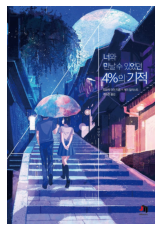

너를 만나기 위해 나는… 
다시 한 번 ‘그곳’으로 갈 거야.
아카리는 결혼을 앞두고 고향인 교토로 돌아온다.
본가에 있는 아카리의 방은 고등학교 시절 이후로 시간이 멈춰 있는 듯 그대로였다.
그리고 방 안 서랍 안에서, 아카리는 예전에 자신이 썼던 일기장을 발견한다.
모르는 사람을 발견했다. 이름은 「     」.
우리는 친구가 되었다.
부자연스럽게 이름이 지워져 있는 일기.
다른 날의 일기를 살펴보아도, 마찬가지로 특정 부분의 이름이 지워져 있었다.
기억을 더듬어보지만, 지워진 이름의 존재에 대한 기억은 없었다.
하지만 교토에 머무는 시간 동안, 
아카리는 지워진 인물과 관련된 흔적을 발견하게 되고, 
잊혀진 기억 속의 무언가가 가슴을 꾹 옥죄는 느낌과 함께-
17살의 그 시절, 잊어서는 안 될 무언가가 있었다는 것을 깨닫게 되는데……. -절대로 잊을 수 없는 사랑이 있을까?
-운명적인 사랑이란 무엇일까?
아름다운 교토를 배경으로 한 히로세 미이의 연애 판타지!
푸른 달이 뜨는 날 밤에, 기적 같은 인연이 찾아온다!
블루문(Blue Moon)이 뜬 밤, 그녀에겐 무슨 일이 일어난 것인가?
이름이 지워진 일기장, 머릿속을 꿈처럼 맴도는 어렴풋한 기억……
17살 때의 7월 여름, 절대로 잊고 싶지 않았던, 
잊어서는 안 될 무언가가 있었다.
“4%밖에 없는 세계에, 또 하나의 내가 있다.”
달이 지나기 전, 두 번째 뜨는 보름달.
블루문의 밤 아래 펼쳐지는 애달픈 사랑의 기적-!


In [3]:
NOVEL_CODE = "89960056" # 11995840 35716967 71990844

##############################################################################

def get_url(code):
    return f"http://www.yes24.com/Product/Goods/{code}"


CSS_NOVEL_INTRO = '#infoset_introduce .txtContentText'
CSS_NOVEL_PUB_REVIEW = '#infoset_pubReivew .infoWrap_txt'
CSS_NOVEL_IMG = '.gd_imgArea img'

# Attribute for img url
ATTR_IMAGE_URL = 'src'

##############################################################################

url = get_url(NOVEL_CODE)
soup = BeautifulSoup(requests.get(url).text, 'html.parser')

img = soup.select(CSS_NOVEL_IMG)

print(not img)

if img:
    img = img[0]['src']
    intro = soup.select(CSS_NOVEL_INTRO)
    pub_review = soup.select(CSS_NOVEL_PUB_REVIEW)
    
    img = Image.open(requests.get(img, stream=True).raw)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    info = []
    
    if intro:
        info.append(intro[0].get_text("\n").strip())
    if pub_review:
        info.append(pub_review[0].get_text("\n").strip())
    print(' '.join(info))

In [24]:
novels = pd.read_csv('./crawling/book_Europe.csv', index_col=0)
print(novels)

                               title  \
code                                   
69280130    가장 어두운 방 - 욀란드의 사계 시리즈 2   
24303183           감옥에 가기로 한 메르타 할머니   
50172893        거미줄에 걸린 소녀 - 밀레니엄 4권   
8614731                           게임   
14207430                   굶주림 (개정판)   
...                              ...   
78907401      The Golden Lion (황금사자)   
78708801   The Merry Wives (즐거운 아내들)   
19361940          [세트] 요나스 요나손 특별 세트   
76649558  [세트] 헨닝망켈 북유럽 스릴러 3종 (총3권)   
24512345               かえるの王さま 개구리왕자   

                                                        img  \
code                                                          
69280130        http://image.yes24.com/goods/69280130/800x0   
24303183  http://image.yes24.com/momo/TopCate0001/kepub/...   
50172893        http://image.yes24.com/goods/50172893/800x0   
8614731   http://image.yes24.com/momo/TopCate0001/kepub/...   
14207430  http://image.yes24.com/momo/TopCate0001/kepub/...   
...                                   

In [27]:
novels = pd.read_csv('./crawling/book_code_Europe.csv', index_col=0)
novels

,title
code,
69280130,가장 어두운 방 - 욀란드의 사계 시리즈 2
24303183,감옥에 가기로 한 메르타 할머니
50172893,거미줄에 걸린 소녀 - 밀레니엄 4권
8614731,게임
14207430,굶주림 (개정판)
...,...
19361940,[세트] 요나스 요나손 특별 세트
76649558,[세트] 헨닝망켈 북유럽 스릴러 3종 (총3권)
24512345,かえるの王さま 개구리왕자


In [83]:
novels = pd.read_csv('./datasets/book_code_spanish.csv', index_col=0)
print(novels)
print(novels.index)

                                                      title
code                                                       
9167968                      검은 양과 또 다른 우화들 - 지식을만드는지식 소설선집
79633118                             경이로운 도시 1 - 세계문학전집 255
79633119                             경이로운 도시 2 - 세계문학전집 256
18038042                                               고 GO
91560829                            고양이는 내게 행복하라고 말했다 (개정판)
...                                                     ...
61356124                                             2666 5
90373622                                            7개의 목소리
6139411                                            7인의 미치광이
15119005                      Don Quixote - 영어로 읽는 세계문학 250
41699094  The Exemplary Novels of Cervantes - 영어로 읽는 세계문...

[136 rows x 1 columns]
Int64Index([ 9167968, 79633118, 79633119, 18038042, 91560829, 13515964,
             7464983, 90300272, 73418366, 32294628,
            ...
            24758914, 61356128, 61356127, 61356126, 6135

In [85]:
LANGUAGE = 'german'

BOOK_FILE = f'./datasets/book_code_{LANGUAGE}.csv'
SAVE_FILE = f'./datasets/book_{LANGUAGE}.csv'

##############################################################################


def get_url(code):
    return f"http://www.yes24.com/Product/Goods/{code}"


# CSS selectors
CSS_BOOK_INTRO = '#infoset_introduce .txtContentText'
CSS_BOOK_PUB_REVIEW = '#infoset_pubReivew .infoWrap_txt'
CSS_BOOK_IMG = '.gd_imgArea img'

# Attribute for img url
ATTR_IMAGE_URL = 'src'

##############################################################################

df_book = pd.read_csv(BOOK_FILE, index_col=0)

imgs = []
infos = []

try:
    for book_code in df_book.index:
        url = get_url(book_code)
        soup = BeautifulSoup(requests.get(url).text, 'html.parser')

        img = soup.select(CSS_BOOK_IMG)

        if not img:
            continue

        img = img[0].get('src')

        info = []

        intro = soup.select(CSS_BOOK_INTRO)
        if intro:
            info.append(intro[0].get_text("\n").strip())

        pub_review = soup.select(CSS_BOOK_PUB_REVIEW)
        if pub_review:
            info.append(pub_review[0].get_text("\n").strip())

        imgs.append(img)
        infos.append(' '.join(info))

    df_book['img'] = imgs
    df_book['info'] = infos
    df_book.to_csv(SAVE_FILE)

except:
    length = len(infos)
    df_result = df_book.iloc[:length].copy()

    df_result['img'] = imgs[:length]
    df_result['info'] = infos
    df_result.to_csv(SAVE_FILE)

                                                      title  \
code                                                          
9167968                      검은 양과 또 다른 우화들 - 지식을만드는지식 소설선집   
79633118                             경이로운 도시 1 - 세계문학전집 255   
79633119                             경이로운 도시 2 - 세계문학전집 256   
18038042                                               고 GO   
91560829                            고양이는 내게 행복하라고 말했다 (개정판)   
...                                                     ...   
61356124                                             2666 5   
90373622                                            7개의 목소리   
6139411                                            7인의 미치광이   
15119005                      Don Quixote - 영어로 읽는 세계문학 250   
41699094  The Exemplary Novels of Cervantes - 영어로 읽는 세계문...   

                                                        img  \
code                                                          
9167968   http://image.yes24.com/momo/TopCate0001/kepu

## .text vs. .get_text()

In [4]:
from bs4 import BeautifulSoup
import requests

BOOK_CODE = 60789936

##############################################################################

def get_url(code):
    return f"http://www.yes24.com/Product/Goods/{code}"


# CSS selectors
CSS_BOOK_INTRO = '#infoset_introduce .txtContentText'
CSS_BOOK_PUB_REVIEW = '#infoset_pubReivew .infoWrap_txt'
CSS_BOOK_IMG = '.gd_imgArea img'

# Attribute for img url
ATTR_IMAGE_URL = 'src'

##############################################################################

url = get_url(BOOK_CODE)
soup = BeautifulSoup(requests.get(url).text, 'html.parser')

img = soup.select(CSS_BOOK_IMG)

if img:
    intro = soup.select(CSS_BOOK_INTRO)
    pub_review = soup.select(CSS_BOOK_PUB_REVIEW)
    
    if intro:
        print(intro[0].text.strip())
        print('------------------------------------')
        print(intro[0].get_text("\n").strip())
        print('------------------------------------')
        
    if pub_review:
        print(pub_review[0].text.strip())
        print('------------------------------------')
        print(pub_review[0].get_text("\n").strip())

“주말에 뭐 하세요?”아쿠타가와상 수상 작가가 섬세한 감성으로 포착해낸 평범하면서도 특별한 여덟 가지 주말 풍경금요일 오후 8시 혹은 9시, 어쩌면 우리가 가장 행복해지는 시간. 아마도 주말이 기다리고 있기 때문일 것이다. 주말이 없는 삶을 상상할 수 있을까? 평소처럼 지나가버리기도 하지만, 그래도 주말은 특별한 날, 빛나는 날, 왠지 무슨 일인가 일어날 것만 같아 설레는 날이다. 해야 하는 일들이 쌓여 있는 정신없는 의무감에서 해방될 수 있는 이완의 날이기도 하다. 그래서일까, 주말에는 평소에는 보이지 않았던 무언가가 보이기도 하고, 평소에는 보지 않았던 무언가를 보고 싶어지기도 한다.   『곧, 주말』은 그런 ‘주말’을 소재로 삼아, 토요일 혹은 일요일의 풍경을 담아낸 소설집이다. 일상을 묘사하는 섬세하고 사려 깊은 감성으로 주목받고 있는 시바사키 토모카의 작품으로, 아쿠타가와상 후보였던 「하르툼에 나는 없다」를 비롯해, 아웃도어 제품을 팔지만 산도 바다도 강도 좋아하지 않는 옷가게 점원의 주말(「여기서 먼 곳」), 열아홉 살의 자기를 만나는 서른한 살 여자의 주말(「해피하고 뉴, 하지만은 않지만」), 곧 문을 닫게 될 낯선 서점에서 사진집을 선물로 받는 주말(「개구리 왕자와 할리우드」), 등 보통의 존재들의 주말 풍경을 절묘하게 포착한 여덟 편의 단편이 수록되어 있다. 현지의 독자들은 “천천히 마음에 스며들다가 어느덧 정신없이 읽게 되는 단편집” “무심한 듯 포착한 휴일의 한 장면. 그들보다 더욱 심심한 휴일을 보내는 누군가에게는 휴일을 선물 받은 느낌을 안겨줄 것이다” “시바사키 토모카는 찰나의 풍경을 소중히 하는 작가이다. 같은 순간은 두 번 찾아오지 않기 때문이다” “무척 좋았다. 공감하며 읽었다”라고 리뷰하고 있다. 평온한 일상이 없다면 삶은 지금보다 훨씬 더 힘겨워질 것이다. 시바사키 토모카의 『곧 주말』은 그런 평온한 주말에 읽기에 맞춤한 책이다. 어떤 약속도 없는 고요한 주말에, 알람 없이 맘 편히 일어나, 커피를 마시며 한 편씩 느리게.
-

# Others

In [11]:
df_korea = pd.read_csv('./data_raw/book_code_Korea.csv', index_col=0)
print(df_korea.info())

df_korea1 = df_korea.iloc[:6000]
df_korea2 = df_korea.iloc[6000:12000]
df_korea3 = df_korea.iloc[12000:]

print(df_korea1)
print(df_korea2)
print(df_korea3)

df_korea1.to_csv('./data_raw/book_code_Korea_1.csv')
df_korea2.to_csv('./data_raw/book_code_Korea_2.csv')
df_korea3.to_csv('./data_raw/book_code_Korea_3.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17963 entries, 14148895 to 78565383
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   17963 non-null  object
dtypes: object(1)
memory usage: 280.7+ KB
None
                         title
code                          
14148895             錦 山 , 錦 江
27129801              가가 가라니까!
57952677                    가객
57508209                   가거라
56901241                   가거라
...                        ...
28334917                   반석평
8453302   반야의 죽음(김동인 역사/야담 소설)
67452974                 반역 01
67452973                 반역 02
67452972                 반역 03

[6000 rows x 1 columns]
                                    title
code                                     
67452971                            반역 04
67452970                            반역 05
67452969                            반역 06
67452968                            반역 07
67452967                            반역 08
...  

In [20]:
df_test = pd.DataFrame({'c' + str(i): [j for j in range(3)] for i in range(2)})
print(df_test)

# df_test['c2'] = [0, 0]

df_2 = df_test[df_test['c0'] < 2].copy()
df_2['c2'] = [0, 0]

print(df_2)

   c0  c1
0   0   0
1   1   1
2   2   2
   c0  c1  c2
0   0   0   0
1   1   1   0


In [21]:
print(len(df_2.index))


2


In [99]:
test = []

print(' '.join(test))